<a href="https://colab.research.google.com/github/raunakkbanerjee/NLP-assignment/blob/main/CSR_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import os
import scipy.io as io
import glob
from scipy.ndimage.filters import gaussian_filter 
import scipy
import scipy.spatial
import json
from matplotlib import cm as CM
import h5py
from PIL import Image
import PIL.Image as Image
from torch.utils.data import Dataset
import random
from torchvision import models, transforms
from argparse import ArgumentParser

In [2]:
# Instantiates the device to be used as GPU/CPU based on availability
device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
print(torch.__version__)

1.9.0+cu111


In [4]:
!wget -O shanghaitech "https://www.dropbox.com/s/c0upee7nhr6r2o7/ShanghaiTech_Crowd_Counting_Dataset.zip?dl=0"

--2021-11-10 06:05:41--  https://www.dropbox.com/s/c0upee7nhr6r2o7/ShanghaiTech_Crowd_Counting_Dataset.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/c0upee7nhr6r2o7/ShanghaiTech_Crowd_Counting_Dataset.zip [following]
--2021-11-10 06:05:41--  https://www.dropbox.com/s/raw/c0upee7nhr6r2o7/ShanghaiTech_Crowd_Counting_Dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc35c593471fc158c94a97b1f5ce.dl.dropboxusercontent.com/cd/0/inline/BZu66zbHNxYsg6DJnKe4nxJdXzaK8w3GWSpYO-MtGT-z_qEhutWx0OocDRzGt5zFVe1vGsrdAi2AwWmNNjWutdWC439GBjDLc17ZIFAUtQzRb68c2XO1zP0GuZ5FwOU1yLQMj9UY5Rl6nuLvriAvrAcM/file# [following]
--2021-11-10 06:05:42--  https://uc35c593471fc158c94a97b1f5ce.dl.dropboxusercontent.com/cd/0/inline/BZu

In [5]:
!unzip "/content/shanghaitech" 

Archive:  /content/shanghaitech
   creating: part_A_final/
   creating: part_A_final/train_data/
   creating: part_A_final/test_data/
   creating: part_A_final/train_data/images/
  inflating: part_A_final/train_data/images/IMG_213.jpg  
  inflating: part_A_final/train_data/images/IMG_212.jpg  
  inflating: part_A_final/train_data/images/IMG_211.jpg  
  inflating: part_A_final/train_data/images/IMG_210.jpg  
  inflating: part_A_final/train_data/images/IMG_21.jpg  
  inflating: part_A_final/train_data/images/IMG_209.jpg  
  inflating: part_A_final/train_data/images/IMG_208.jpg  
  inflating: part_A_final/train_data/images/IMG_207.jpg  
  inflating: part_A_final/train_data/images/IMG_206.jpg  
  inflating: part_A_final/train_data/images/IMG_205.jpg  
  inflating: part_A_final/train_data/images/IMG_204.jpg  
  inflating: part_A_final/train_data/images/IMG_203.jpg  
  inflating: part_A_final/train_data/images/IMG_202.jpg  
  inflating: part_A_final/train_data/images/IMG_201.jpg  
  inflatin

In [18]:
def gaussian_filter_density(gt):
    print(gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(np.column_stack((np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print('done.')
    return density

In [19]:
root = '/content/'

In [20]:
#now generate the ShanghaiA's ground truth
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
path_sets = [part_A_train,part_A_test]

In [21]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [23]:
len(img_paths)

482

In [ ]:
for img_path in img_paths[:10]:#This code block takes time to run
    print(img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

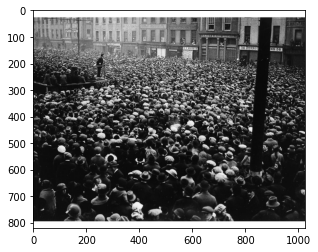

In [29]:
plt.imshow(Image.open(img_paths[0]))

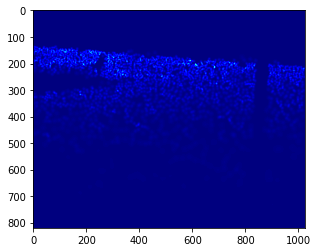

In [30]:
gt_file = h5py.File(img_paths[0].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [32]:
path_sets = [part_B_train,part_B_test]

In [33]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [34]:
len(img_paths)

716

In [36]:
for img_path in img_paths[:10]:
    print(img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter(k,15)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

/content/part_B_final/train_data/images/IMG_79.jpg
/content/part_B_final/train_data/images/IMG_391.jpg
/content/part_B_final/train_data/images/IMG_245.jpg
/content/part_B_final/train_data/images/IMG_264.jpg
/content/part_B_final/train_data/images/IMG_60.jpg
/content/part_B_final/train_data/images/IMG_72.jpg
/content/part_B_final/train_data/images/IMG_211.jpg
/content/part_B_final/train_data/images/IMG_179.jpg
/content/part_B_final/train_data/images/IMG_14.jpg
/content/part_B_final/train_data/images/IMG_148.jpg


In [37]:
def load_data(img_path,train = True):
    gt_path = img_path.replace('.jpg','.h5').replace('images','ground_truth')
    img = Image.open(img_path).convert('RGB')
    gt_file = h5py.File(gt_path)
    target = np.asarray(gt_file['density'])
    if False:
        crop_size = (img.size[0]/2,img.size[1]/2)
        if random.randint(0,9)<= -1:
            
            
            dx = int(random.randint(0,1)*img.size[0]*1./2)
            dy = int(random.randint(0,1)*img.size[1]*1./2)
        else:
            dx = int(random.random()*img.size[0]*1./2)
            dy = int(random.random()*img.size[1]*1./2)
        
        
        
        img = img.crop((dx,dy,crop_size[0]+dx,crop_size[1]+dy))
        target = target[dy:crop_size[1]+dy,dx:crop_size[0]+dx]
        
        
        
        
        if random.random()>0.8:
            target = np.fliplr(target)
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
    
    
    
    
    target = cv2.resize(target,(target.shape[1]/8,target.shape[0]/8),interpolation = cv2.INTER_CUBIC)*64
    
    
    return img,target

In [40]:
class listDataset(Dataset):
    def __init__(self, root, shape=None, shuffle=True, transform=None,  train=False, seen=0, batch_size=1, num_workers=4):
        if train:
            root = root *4
        random.shuffle(root)
        
        self.nSamples = len(root)
        self.lines = root
        self.transform = transform
        self.train = train
        self.shape = shape
        self.seen = seen
        self.batch_size = batch_size
        self.num_workers = num_workers
        
        
    def __len__(self):
        return self.nSamples
    def __getitem__(self, index):
        assert index <= len(self), 'index range error' 
        
        img_path = self.lines[index]
        
        img,target = load_data(img_path,self.train)
        
        #img = 255.0 * F.to_tensor(img)
        
        #img[0,:,:]=img[0,:,:]-92.8207477031
        #img[1,:,:]=img[1,:,:]-95.2757037428
        #img[2,:,:]=img[2,:,:]-104.877445883


        
        
        if self.transform is not None:
            img = self.transform(img)
        return img,target

In [44]:
def save_net(fname, net):
    with h5py.File(fname, 'w') as h5f:
        for k, v in net.state_dict().items():
            h5f.create_dataset(k, data=v.cpu().numpy())
def load_net(fname, net):
    with h5py.File(fname, 'r') as h5f:
        for k, v in net.state_dict().items():        
            param = torch.from_numpy(np.asarray(h5f[k]))         
            v.copy_(param)
            
def save_checkpoint(state, is_best,task_id, filename='checkpoint.pth.tar'):
    torch.save(state, task_id+filename)
    if is_best:
        shutil.copyfile(task_id+filename, task_id+'model_best.pth.tar')  

In [60]:
class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512,256,128,64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = models.vgg16(pretrained = True)
            self._initialize_weights()
            for i in range(len(self.frontend.state_dict().items())):
                list(self.frontend.state_dict().items())[i][1].data[:] = list(mod.state_dict().items())[i][1].data[:]
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [61]:
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [62]:
model = CSRNet()
x = torch.rand((1,3,255,255))
model(x).shape

torch.Size([1, 1, 31, 31])

In [79]:
trans = transforms.ToTensor()

In [82]:
model = CSRNet()
# model = model.cuda()
# checkpoint = torch.load('model_best.pth.tar')
# model.load_state_dict(checkpoint['state_dict'])
mae = 0
for i in range(len(img_paths[:10])):
    img = 255.0 * trans(Image.open(img_paths[i]).convert('RGB'))

    img[0,:,:]=img[0,:,:]-92.8207477031
    img[1,:,:]=img[1,:,:]-95.2757037428
    img[2,:,:]=img[2,:,:]-104.877445883
    # img = img.cuda()
    #img = transform(Image.open(img_paths[i]).convert('RGB')).cuda()
    gt_file = h5py.File(img_paths[i].replace('.jpg','.h5').replace('images','ground_truth'),'r')
    groundtruth = np.asarray(gt_file['density'])
    output = model(img.unsqueeze(0))
    mae += abs(output.detach().cpu().sum().numpy()-np.sum(groundtruth))
    print(i,mae)
print(mae/len(img_paths[:10]))

0 3.6027974532726844e+16
1 6.741791051926747e+16
2 1.0110648293785621e+17
3 1.3327198479135563e+17
4 1.5475161445485802e+17
5 1.8867962056278067e+17
6 2.1919051847775082e+17
7 2.503155000792848e+17
8 2.891894466438765e+17
9 3.2800757151852224e+17
3.2800757151852224e+16


In [ ]:
# parser = ArgumentParser(description='PyTorch CSRNet')

# parser.add_argument('train_json', metavar='TRAIN',
#                     help='path to train json')
# parser.add_argument('test_json', metavar='TEST',
#                     help='path to test json')

# parser.add_argument('--pre', '-p', metavar='PRETRAINED', default=None,type=str,
#                     help='path to the pretrained model')

# parser.add_argument('gpu',metavar='GPU', type=str,
#                     help='GPU id to use.')

# parser.add_argument('task',metavar='TASK', type=str,
#                     help='task id to use.')

# def main():
    
#     global args,best_prec1
    
#     best_prec1 = 1e6
    
#     args = parser.parse_args()
#     args.original_lr = 1e-7
#     args.lr = 1e-7
#     args.batch_size    = 1
#     args.momentum      = 0.95
#     args.decay         = 5*1e-4
#     args.start_epoch   = 0
#     args.epochs = 400
#     args.steps         = [-1,1,100,150]
#     args.scales        = [1,1,1,1]
#     args.workers = 4
#     args.seed = time.time()
#     args.print_freq = 30
#     with open(args.train_json, 'r') as outfile:        
#         train_list = json.load(outfile)
#     with open(args.test_json, 'r') as outfile:       
#         val_list = json.load(outfile)
    
#     os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu
#     torch.cuda.manual_seed(args.seed)
    
#     model = CSRNet()
    
#     model = model.cuda()
    
#     criterion = nn.MSELoss(size_average=False).cuda()
    
#     optimizer = torch.optim.SGD(model.parameters(), args.lr,
#                                 momentum=args.momentum,
#                                 weight_decay=args.decay)

#     if args.pre:
#         if os.path.isfile(args.pre):
#             print("=> loading checkpoint '{}'".format(args.pre))
#             checkpoint = torch.load(args.pre)
#             args.start_epoch = checkpoint['epoch']
#             best_prec1 = checkpoint['best_prec1']
#             model.load_state_dict(checkpoint['state_dict'])
#             optimizer.load_state_dict(checkpoint['optimizer'])
#             print("=> loaded checkpoint '{}' (epoch {})"
#                   .format(args.pre, checkpoint['epoch']))
#         else:
#             print("=> no checkpoint found at '{}'".format(args.pre))
            
#     for epoch in range(args.start_epoch, args.epochs):
        
#         adjust_learning_rate(optimizer, epoch)
        
#         train(train_list, model, criterion, optimizer, epoch)
#         prec1 = validate(val_list, model, criterion)
        
#         is_best = prec1 < best_prec1
#         best_prec1 = min(prec1, best_prec1)
#         print(' * best MAE {mae:.3f} '
#               .format(mae=best_prec1))
#         save_checkpoint({
#             'epoch': epoch + 1,
#             'arch': args.pre,
#             'state_dict': model.state_dict(),
#             'best_prec1': best_prec1,
#             'optimizer' : optimizer.state_dict(),
#         }, is_best,args.task)

# def train(train_list, model, criterion, optimizer, epoch):
    
#     losses = AverageMeter()
#     batch_time = AverageMeter()
#     data_time = AverageMeter()
    
    
#     train_loader = torch.utils.data.DataLoader(
#         dataset.listDataset(train_list,
#                        shuffle=True,
#                        transform=transforms.Compose([
#                        transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225]),
#                    ]), 
#                        train=True, 
#                        seen=model.seen,
#                        batch_size=args.batch_size,
#                        num_workers=args.workers),
#         batch_size=args.batch_size)
#     print('epoch %d, processed %d samples, lr %.10f' % (epoch, epoch * len(train_loader.dataset), args.lr))
    
#     model.train()
#     end = time.time()
    
#     for i,(img, target)in enumerate(train_loader):
#         data_time.update(time.time() - end)
        
#         img = img.cuda()
#         img = Variable(img)
#         output = model(img)
        
        
        
        
#         target = target.type(torch.FloatTensor).unsqueeze(0).cuda()
#         target = Variable(target)
        
        
#         loss = criterion(output, target)
        
#         losses.update(loss.item(), img.size(0))
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()    
        
#         batch_time.update(time.time() - end)
#         end = time.time()
        
#         if i % args.print_freq == 0:
#             print('Epoch: [{0}][{1}/{2}]\t'
#                   'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
#                   'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
#                   'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
#                   .format(
#                    epoch, i, len(train_loader), batch_time=batch_time,
#                    data_time=data_time, loss=losses))
    
# def validate(val_list, model, criterion):
#     print ('begin test')
#     test_loader = torch.utils.data.DataLoader(
#     dataset.listDataset(val_list,
#                    shuffle=False,
#                    transform=transforms.Compose([
#                        transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225]),
#                    ]),  train=False),
#     batch_size=args.batch_size)    
    
#     model.eval()
    
#     mae = 0
    
#     for i,(img, target) in enumerate(test_loader):
#         img = img.cuda()
#         img = Variable(img)
#         output = model(img)
        
#         mae += abs(output.data.sum()-target.sum().type(torch.FloatTensor).cuda())
        
#     mae = mae/len(test_loader)    
#     print(' * MAE {mae:.3f} '
#               .format(mae=mae))

#     return mae    
        
# def adjust_learning_rate(optimizer, epoch):
#     """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    
    
#     args.lr = args.original_lr
    
#     for i in range(len(args.steps)):
        
#         scale = args.scales[i] if i < len(args.scales) else 1
        
        
#         if epoch >= args.steps[i]:
#             args.lr = args.lr * scale
#             if epoch == args.steps[i]:
#                 break
#         else:
#             break
#     for param_group in optimizer.param_groups:
#         param_group['lr'] = args.lr
        
# class AverageMeter(object):
#     """Computes and stores the average and current value"""
#     def __init__(self):
#         self.reset()

#     def reset(self):
#         self.val = 0
#         self.avg = 0
#         self.sum = 0
#         self.count = 0

#     def update(self, val, n=1):
#         self.val = val
#         self.sum += val * n
#         self.count += n
#         self.avg = self.sum / self.count    
    
# if __name__ == '__main__':
#     main()        